# Visualizing Internal Variables Printed From The User Element Subroutine 

This notebook presents the steps to use the `czmtestkit` package to read and visualize internal variables from the user element subroutine printed to the `.msg` file while running the simulation.
Inorder to use this functionality of the package, print the variable `Var` of interest to the `.msg` file using the following command in the fortran code of the subroutine:

```fortran
        WRITE(7,*) 'VarKey = ', Var
```

Run `ADCB_UEL.ipynb` to generate sample files.
Read the `.msg` file and find the line numbers in the `.msg` file corresponding to the stable increments using `czmtestkit.py_modules.find_convergedIncrements`.

In [6]:
from czmtestkit.py_modules import find_convergedIncrements
File= 'ADCB_UEL\point_05\ADCB_UEL.msg'
converged_time,  last_unconv_it, converged_it = find_convergedIncrements(File)
print('Last line numbers from converged increments:', '\n',converged_it, '\n')
print('Last line numbers from the last increment before converged increments:', '\n', last_unconv_it, '\n')
print('Step times of converged increments:', '\n',converged_time, '\n')

Last line numbers from converged increments: 
 [13275, 19849, 25333, 32927, 43743, 75658, 95899, 103400, 122627, 191886, 213140, 224839, 865040, 1506327, 1537206, 1545720, 1547865, 1555295, 1557440] 

Last line numbers from the last increment before converged increments: 
 [12147, 18734, 24207, 31801, 40518, 74557, 94799, 102300, 121527, 188687, 212040, 223739, 862883, 1505226, 1534007, 1544620, 1544620, 1552094, 1552094] 

Step times of converged increments: 
 ['0.100', '0.200', '0.300', '0.400', '0.500', '0.600', '0.700', '0.800', '0.900', '0.925', '0.950', '0.975', '0.981', '0.984', '0.987', '0.991', '0.994', '0.999', '1.00'] 



Initialize an `increment` class instance for every stable increment and assign the limiting line numbers corresponding to the increment. Line number corresponding to the last line from the increment before a converged increment is the start of the increment and the line number corresponding to the last of converged increment is the end of the increment.

Then, for each stable increment, find the line numbers where the variable `Var` is printed using the key word `VarKey` and the `find_lineNumbers` method.
```python
    increment.findlineNumbers('VarKey', p, (m,n))
```
where p is the number of lines for each entry of the variable `Var` and `m`,`n` are the number of rows and columns.
For example, the variable `Var` is printed to the `.msg` file as 
```
VarKey = 1.000000 2.000000 3.000000
 4.000000 5.000000 6.000000
```
Since the entry extends to two lines the p is 2. Further, if the variable `Var` has two rows and three columns with m = 2 and n = 3. 

`find_lineNumbers` method creates an instance of the `data` class and stores the corresponding line numbers as instance attributes each time the `Var` is printed within the limits of the stable increment. A list of all the `data` class instances created is stored as an attribute of the `increment` class instance.

Further, `find_data` method fetches the data between the line numbers fetched by `find_lineNumbers` method and converts it to matrix of the shape `m,n` for all the `data` class instances in the list. For example above entry is converted to
$$\begin{bmatrix}
1.000000 & 3.000000 & 5.000000\\
2.000000 & 4.000000 & 6.000000
\end{bmatrix}$$

The matix is assigned to the `value` attribute of the corresponding `data` class instance. Finally, `find_data` creates `data` attribute for the `increment` class instance which is a dictionary with the `VarKey` as keys and the lists of corresponding `data` class instances as values.

In [2]:
from czmtestkit.py_modules import increment
entries = []
for j in range(len(converged_it)):
    ent = increment()
    ent.fileName = File
    ent.step_time = converged_time[j]
    ent.start = last_unconv_it[j]
    ent.stop = converged_it[j]
    entries.append(ent)
    ent.find_lineNumbers('IP',1,(2,1))
    ent.find_lineNumbers('GIP',1,(3,1))
    ent.find_lineNumbers('TAU',1,(3,1))
    ent.find_lineNumbers('DTAU',3,(3,3))
    ent.find_lineNumbers('DG',24,(3,24))
    ent.find_lineNumbers('DR',24,(3,24))
    ent.find_data()

Finally, edit the `setup_frame` and `frame_plot` methods of the `frame_iterator` class to present variables of interest as colormaps and create a movie of frames from all the stable increments. Use the `setup_frame` method to setup the plot area, titles, and axes, and `frame_plot` method to plot the increments. 

**Note**: Do not change the input parameters of the setup_frame and frame_plot methods.


In [3]:
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
from matplotlib import animation as animation
%matplotlib inline

class frame_iterator:
    def __init__(self, array, fileName):
        self.mainArray = array
        self.itr = len(array)
        self.name = fileName

    def animate(self): # Animator
        self.setup_frame()
        Writer = animation.FFMpegWriter
        writer = Writer(fps=1, metadata=dict(artist='Nanditha Mudunuru'), bitrate=1800)
        
        anim = animation.FuncAnimation(self.fig, self.frame_plot, frames=self.itr, blit=False, repeat=True)
        anim.save(self.name+'.mp4', writer=writer)

    def setup_frame(self): # Main frame
        fig = plt.figure(figsize=(12,15))
        self.fig = fig

        # dR color map
        ax1 = fig.add_subplot(121)
        self.ax1 = ax1
        ax1.set_title('dR', fontsize=20)
        self.im1 = ax1.imshow(np.zeros([24,3]), cmap='seismic')
        self.fig.colorbar(self.im1, ax=self.ax1, orientation='vertical')

        # Major ticks and labels
        ax1.set_yticks(np.arange(0, 24, 1))
        ax1.set_xticks(np.arange(0, 3, 1))
        ax1.set_yticklabels(np.arange(1, 25, 1))
        ax1.set_xticklabels(np.arange(1, 4, 1))

        # Minor ticks and grid
        ax1.set_yticks(np.arange(-.5, 24, 1), minor=True)
        ax1.set_xticks(np.arange(-.5, 3, 1), minor=True)
        ax1.grid(which='minor', color='black', linewidth=2)

        # tau color map
        ax2 = fig.add_subplot(222)
        self.ax2 = ax2
        ax2.set_title('\u03C4', fontsize=20)
        self.im2 = ax2.imshow(np.zeros([3,1]), cmap='seismic')
        self.fig.colorbar(self.im2, ax=self.ax2, orientation='vertical')

        # Major ticks and labels
        ax2.set_xticks(np.arange(0, 1, 1))
        ax2.set_yticks(np.arange(0, 3, 1))
        ax2.set_xticklabels(np.arange(1, 2, 1))
        ax2.set_yticklabels(np.arange(1, 4, 1))

        # Minor ticks and grid
        ax2.set_xticks(np.arange(-.5, 1, 1), minor=True)
        ax2.set_yticks(np.arange(-.5, 3, 1), minor=True)
        ax2.grid(which='minor', color='black', linewidth=2)

        # GIP color map
        ax3 = fig.add_subplot(224)
        self.ax3 = ax3
        ax3.set_title(r'$\Delta(e_i)$', fontsize=20)
        self.im3 = ax3.imshow(np.zeros([3,1]), cmap='seismic')
        self.fig.colorbar(self.im3, ax=self.ax3, orientation='vertical')

        # Major ticks and labels
        ax3.set_xticks(np.arange(0, 1, 1))
        ax3.set_yticks(np.arange(0, 3, 1))
        ax3.set_xticklabels(np.arange(1, 2, 1))
        ax3.set_yticklabels(np.arange(1, 4, 1))

        # Minor ticks and grid
        ax3.set_xticks(np.arange(-.5, 1, 1), minor=True)
        ax3.set_yticks(np.arange(-.5, 3, 1), minor=True)
        ax3.grid(which='minor', color='black', linewidth=2)

        return

    def frame_plot(self, i): # Frame update at each stable increment
        IP_idx = 0
        dr = self.mainArray[i].data['DR'][IP_idx].value.T
        tau = self.mainArray[i].data['TAU'][IP_idx].value
        gip = self.mainArray[i].data['GIP'][IP_idx].value
        time = self.mainArray[i].step_time

        self.fig.suptitle('Step Time = {}'.format(time), fontsize=26)
        self.im1.set_data(dr)
        self.im2.set_data(tau)
        self.im3.set_data(gip)
        return

test = frame_iterator(entries, 'h_u=8')
test.animate()
plt.close()
display.Video("h_u=8.mp4")

Or plot individual frames from required increments 

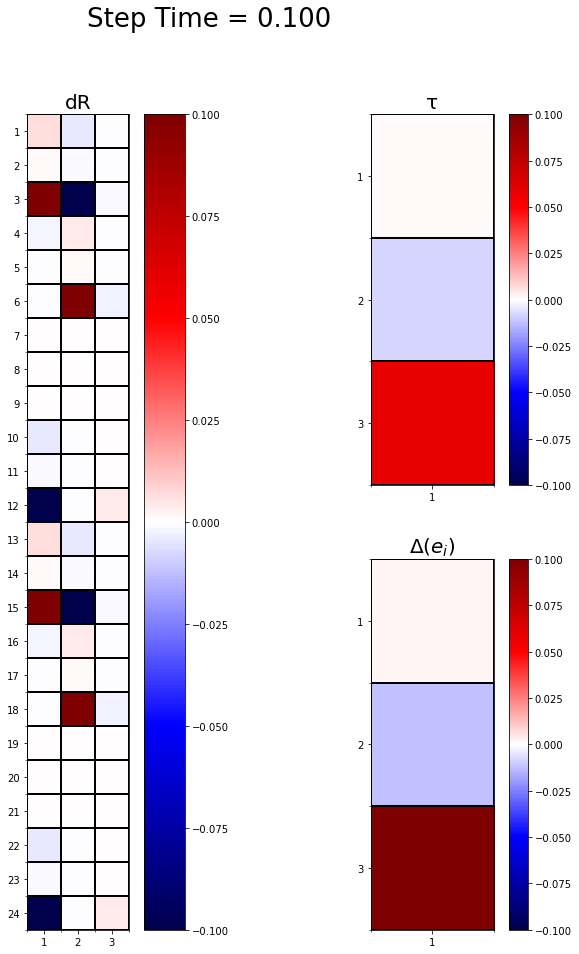

In [5]:
test.setup_frame()
test.frame_plot(0)
plt.show()